In [1]:
%matplotlib inline

import os
import sys
import math
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import invisible_cities.reco.dst_functions as dstf

from   invisible_cities.database               import load_db
from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.reco.xy_algorithms     import barycenter
from   invisible_cities.io.hits_io             import load_hits
from   invisible_cities.io.dst_io              import load_dst
from   invisible_cities.io.mcinfo_io           import load_mcsensor_response
from   invisible_cities.io.mcinfo_io           import read_mcsns_response
from   invisible_cities.io.mcinfo_io           import read_mcsns_response_evt
from   invisible_cities.io.mcinfo_io           import load_mcparticles
from   invisible_cities.io.mcinfo_io           import load_mchits
from   invisible_cities.io.mcinfo_io           import read_mcinfo

import invisible_cities.core.fit_functions  as fitf
from   invisible_cities.icaro.hst_functions import hist
from   invisible_cities.core.core_functions import in_range

In [3]:
## style
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   
    
blue = tableau20[0]
green = tableau20[4]
red = tableau20[6]
pink = tableau20[7]
purple = tableau20[8]
light_purple = tableau20[9]
brown = tableau20[10]
grey = tableau20[15]

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 10, 7.5

In [4]:

## functions to fit
def twogauss(x, amp0, mu0, sigma0, amp, mu, sigma):
    return  amp0/(2*np.pi)**.5/sigma0 * np.exp(-0.5*(x-mu0)**2./sigma0**2.) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def threegauss(x, amp0, mu0, sigma0, amp1, mu1, sigma1, amp, mu, sigma):
    return  amp0/(2*np.pi)**.5/sigma0 * np.exp(-0.5*(x-mu0)**2./sigma0**2.) + amp1/(2*np.pi)**.5/sigma1 * np.exp(-0.5*(x-mu1)**2./sigma1**2.) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def gauss(x, amp, mu, sigma):
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def exp(x, a0, tau):
    return a0 * np.exp(x/tau) 

def expgauss(x, a0, tau, amp, mu, sigma):
    return a0 * np.exp(x/tau) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

In [5]:
reco_r1 = reco_r2 = reco_phi1 = reco_phi2 = reco_z1 = reco_z2 = []
photo_response1_int = photo_response2_int = photo_response1_ext = photo_response2_ext = []
photo_response1 = photo_response2 = []

reco_r1_thr2 = reco_r2_thr2 = reco_phi1_thr2 = reco_phi2_thr2 = reco_z1_thr2 = reco_z2_thr2 = []
reco_r1_thr3 = reco_r2_thr3 = reco_phi1_thr3 = reco_phi2_thr3 = reco_z1_thr3 = reco_z2_thr3 = []
photo_response1_int_thr2 = photo_response2_int_thr2 = photo_response1_ext_thr2 = photo_response2_ext_thr2 = []
photo_response1_int_thr3 = photo_response2_int_thr3 = photo_response1_ext_thr3 = photo_response2_ext_thr3 = []
photo_response1_thr2 = photo_response2_thr2 = []
photo_response1_thr3 = photo_response2_thr3 = []

file_base = '/Users/paola/PETALO/analysis/observables/photoelectric/'
filenames = ['full_ring_depth3cm_pitch4mm_phot_geo_map_{0}_{1}_0.npz', 
             'full_ring_depth3cm_pitch4mm_phot_geo_map_{0}_{1}_2.npz',
             'full_ring_depth3cm_pitch4mm_phot_geo_map_{0}_{1}_3.npz']

rad_min = 100

bunch = 5
for f in range(0, 600, bunch):
    for i, fn in enumerate(filenames, start=0):
        filename = file_base + fn.format(f, bunch)
        try:
            #print(filename)
            d = np.load(filename)
        except:
            print('No')
            continue  
            
        if i == 0:   
            photo_response1_int = np.concatenate((photo_response1_int, d['a_photo_response1_int']))
            photo_response2_int = np.concatenate((photo_response2_int, d['a_photo_response2_int']))
            #photo_response1_ext = np.concatenate((photo_response1_ext, d['a_photo_response1_ext']))
            photo_response2_ext = np.concatenate((photo_response2_ext, d['a_photo_response2_ext']))
            photo_response1 = np.concatenate((photo_response1, d['a_photo_response1']))
            photo_response2 = np.concatenate((photo_response2, d['a_photo_response2']))

            reco_r1 = np.concatenate((reco_r1, d['a_reco_r1']-rad_min))
            reco_r2 = np.concatenate((reco_r2, d['a_reco_r2']-rad_min))
            reco_phi1 = np.concatenate((reco_phi1, d['a_reco_phi1']))
            reco_phi2 = np.concatenate((reco_phi2, d['a_reco_phi2']))
            reco_z1 = np.concatenate((reco_z1, d['a_reco_z1']))
            reco_z2 = np.concatenate((reco_z2, d['a_reco_z2']))
    
        if i == 1:
            photo_response1_int_thr2 = np.concatenate((photo_response1_int_thr2, d['a_photo_response1_int']))
            photo_response2_int_thr2 = np.concatenate((photo_response2_int_thr2, d['a_photo_response2_int']))
            #photo_response1_ext_thr2 = np.concatenate((photo_response1_ext_thr2, d['a_photo_response1_ext']))
            photo_response2_ext_thr2 = np.concatenate((photo_response2_ext_thr2, d['a_photo_response2_ext']))
            photo_response1_thr2 = np.concatenate((photo_response1_thr2, d['a_photo_response1']))
            photo_response2_thr2 = np.concatenate((photo_response2_thr2, d['a_photo_response2']))

            reco_r1_thr2 = np.concatenate((reco_r1_thr2, d['a_reco_r1']-rad_min))
            reco_r2_thr2 = np.concatenate((reco_r2_thr2, d['a_reco_r2']-rad_min))
            reco_phi1_thr2 = np.concatenate((reco_phi1_thr2, d['a_reco_phi1']))
            reco_phi2_thr2 = np.concatenate((reco_phi2_thr2, d['a_reco_phi2']))
            reco_z1_thr2 = np.concatenate((reco_z1_thr2, d['a_reco_z1']))
            reco_z2_thr2 = np.concatenate((reco_z2_thr2, d['a_reco_z2']))

        if i == 2:
            photo_response1_int_thr3 = np.concatenate((photo_response1_int_thr3, d['a_photo_response1_int']))
            photo_response2_int_thr3 = np.concatenate((photo_response2_int_thr3, d['a_photo_response2_int']))
            #photo_response1_ext_thr3 = np.concatenate((photo_response1_ext_thr3, d['a_photo_response1_ext']))
            photo_response2_ext_thr3 = np.concatenate((photo_response2_ext_thr3, d['a_photo_response2_ext']))
            photo_response1_thr3 = np.concatenate((photo_response1_thr3, d['a_photo_response1']))
            photo_response2_thr3 = np.concatenate((photo_response2_thr3, d['a_photo_response2']))

            reco_r1_thr3 = np.concatenate((reco_r1_thr3, d['a_reco_r1']-rad_min))
            reco_r2_thr3 = np.concatenate((reco_r2_thr3, d['a_reco_r2']-rad_min))
            reco_phi1_thr3 = np.concatenate((reco_phi1_thr3, d['a_reco_phi1']))
            reco_phi2_thr3 = np.concatenate((reco_phi2_thr3, d['a_reco_phi2']))
            reco_z1_thr3 = np.concatenate((reco_z1_thr3, d['a_reco_z1']))
            reco_z2_thr3 = np.concatenate((reco_z2_thr3, d['a_reco_z2']))

### Which threshold are we looking at?

In [38]:
threshold = 3
added_string = 'thr{}'.format(threshold)

In [39]:
if threshold == 0:
    valid1 = reco_z1 < 1.e9
    valid2 = reco_z2 < 1.e9
    reco_z = np.concatenate((reco_z1[valid1], reco_z2[valid2]))
    reco_r = np.concatenate((reco_r1[valid1], reco_r1[valid2]))
    photo_response = np.concatenate((photo_response1[valid1], photo_response2[valid2]))  
elif threshold == 2:
    valid1 = reco_z1_thr2 < 1.e9
    valid2 = reco_z2_thr2 < 1.e9
    reco_z = np.concatenate((reco_z1_thr2[valid1], reco_z2_thr2[valid2]))
    reco_r = np.concatenate((reco_r1_thr2[valid1], reco_r1_thr2[valid2]))
    photo_response = np.concatenate((photo_response1_thr2[valid1], photo_response2_thr2[valid2]))  
elif threshold == 3:
    valid1 = reco_z1_thr3 < 1.e9
    valid2 = reco_z2_thr3 < 1.e9
    reco_z = np.concatenate((reco_z1_thr3[valid1], reco_z2_thr3[valid2]))
    reco_r = np.concatenate((reco_r1_thr3[valid1], reco_r1_thr3[valid2]))
    photo_response = np.concatenate((photo_response1_thr3[valid1], photo_response2_thr3[valid2]))  

In [40]:
Lrange = -25, 25
Rrange = 0, 30
Lnbins = [10, 20, 25]
Rnbins = [6, 12, 15]
nL, nR  =    3,   3

# Plotting style
default_cmap = "viridis"
figure_size  = 22, 18
font_size    = 15

save_plots   = True
with_titles  = False
plots_format = "pdf"
plots_output_folder = "/Users/paola/PETALO/analysis/plots/test"

In [41]:
import os
import time
import collections
import warnings

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import plot_writer

from icaro.core.fit_functions import gauss_seed
from icaro.core.fit_functions import relative_errors
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(with_titles)
save   = plot_writer(plots_output_folder, plots_format) if save_plots else lambda *x: None

In [42]:
Lbins    = {n: np.linspace(*Lrange,   n     + 1) for n in Lnbins}
Lcenters = {n: shift_to_bin_centers(bins)         for n, bins in Lbins.items()}
Lpitch   = {n: np.diff(bins)[0]                   for n, bins in Lbins.items()}
Rbins    = {n: np.linspace(*Rrange,   n     + 1) for n in Rnbins}
Rcenters = {n: shift_to_bin_centers(bins)         for n, bins in Rbins.items()}
Rpitch   = {n: np.diff(bins)[0]                   for n, bins in Rbins.items()}

correction_filename  = '/Users/paola/PETALO/analysis/corrections_full_ring_4mm_{}'.format(added_string) + '.h5'
print(correction_filename)
correction_filenames = {}
n = 0
for pL, pR in zip(Lpitch.items(), Rpitch.items()):
    correction_filenames[n] = correction_filename.replace(".h5", "_GEO{pL:.1f}mm_{pR:.1f}mm_{added_string}.h5")
    n += 1

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

warnings.filterwarnings('ignore', category=tb.NaturalNameWarning)

/Users/paola/PETALO/analysis/corrections_full_ring_4mm_thr3.h5


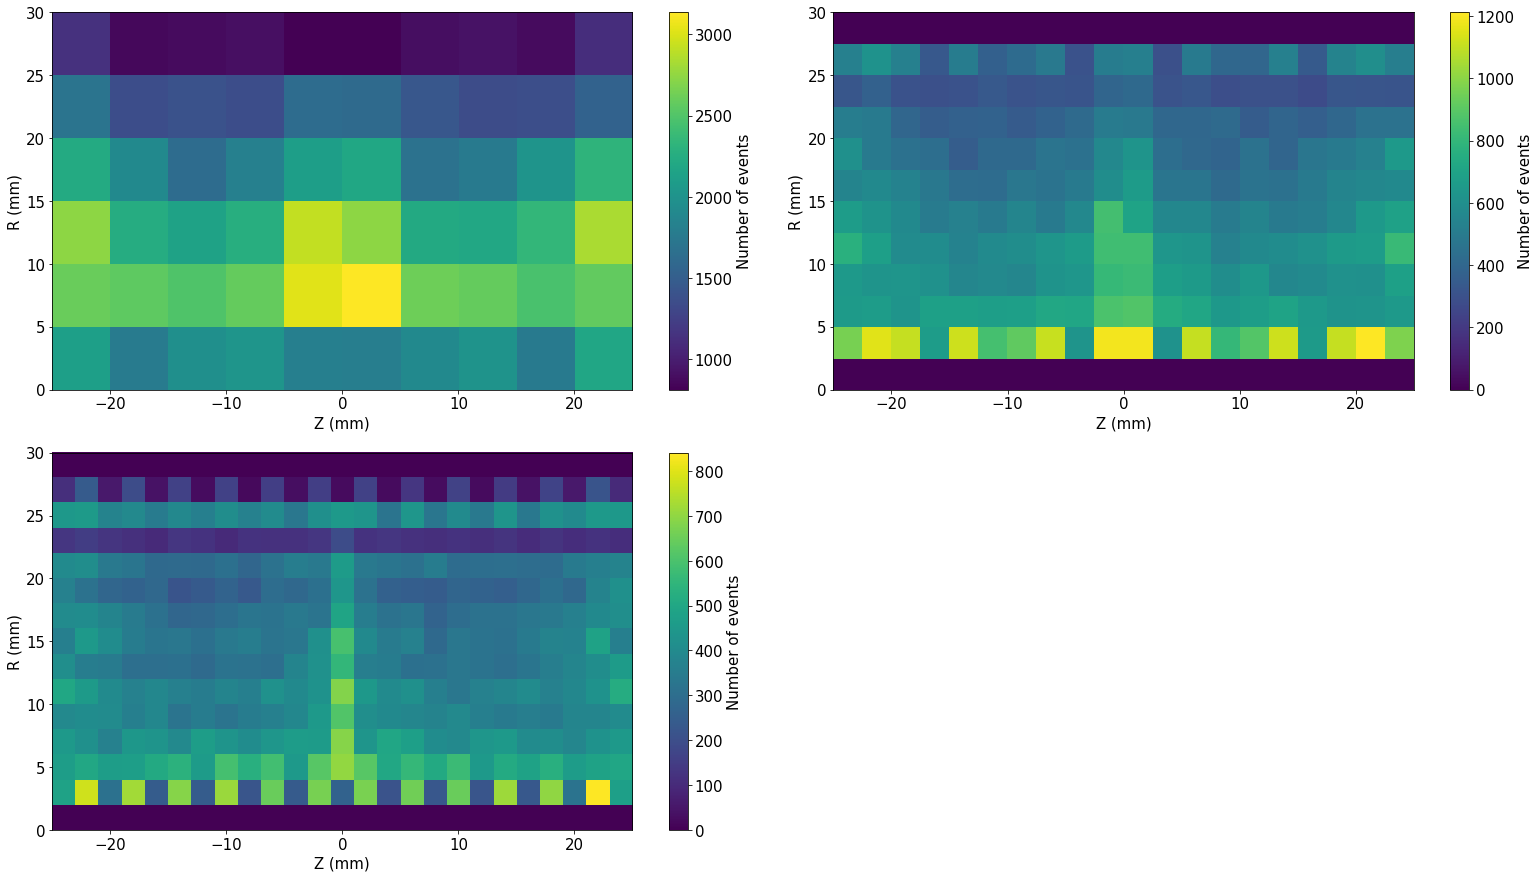

In [43]:
Nevt = {}
i    = 1
for nL, nR in zip(Lnbins, Rnbins):
    lbins  = Lbins [nL]
    rbins  = Rbins [nR]
    lpitch = Lpitch[nL]
    rpitch = Rpitch[nR]

    plt.subplot(3, 2, i)
    nevt, *_ = plt.hist2d(reco_z, reco_r, (lbins, rbins))
    plt.colorbar().set_label("Number of events")
    labels("Z (mm)", "R (mm)", f"Event distribution for {lpitch:.1f} and {rpitch:.1f} mm pitch")

    Nevt[(nL, nR)]  = nevt
    i       += 1

plt.tight_layout()
save("Event_distribution_different_pitches_ZR_" + added_string)

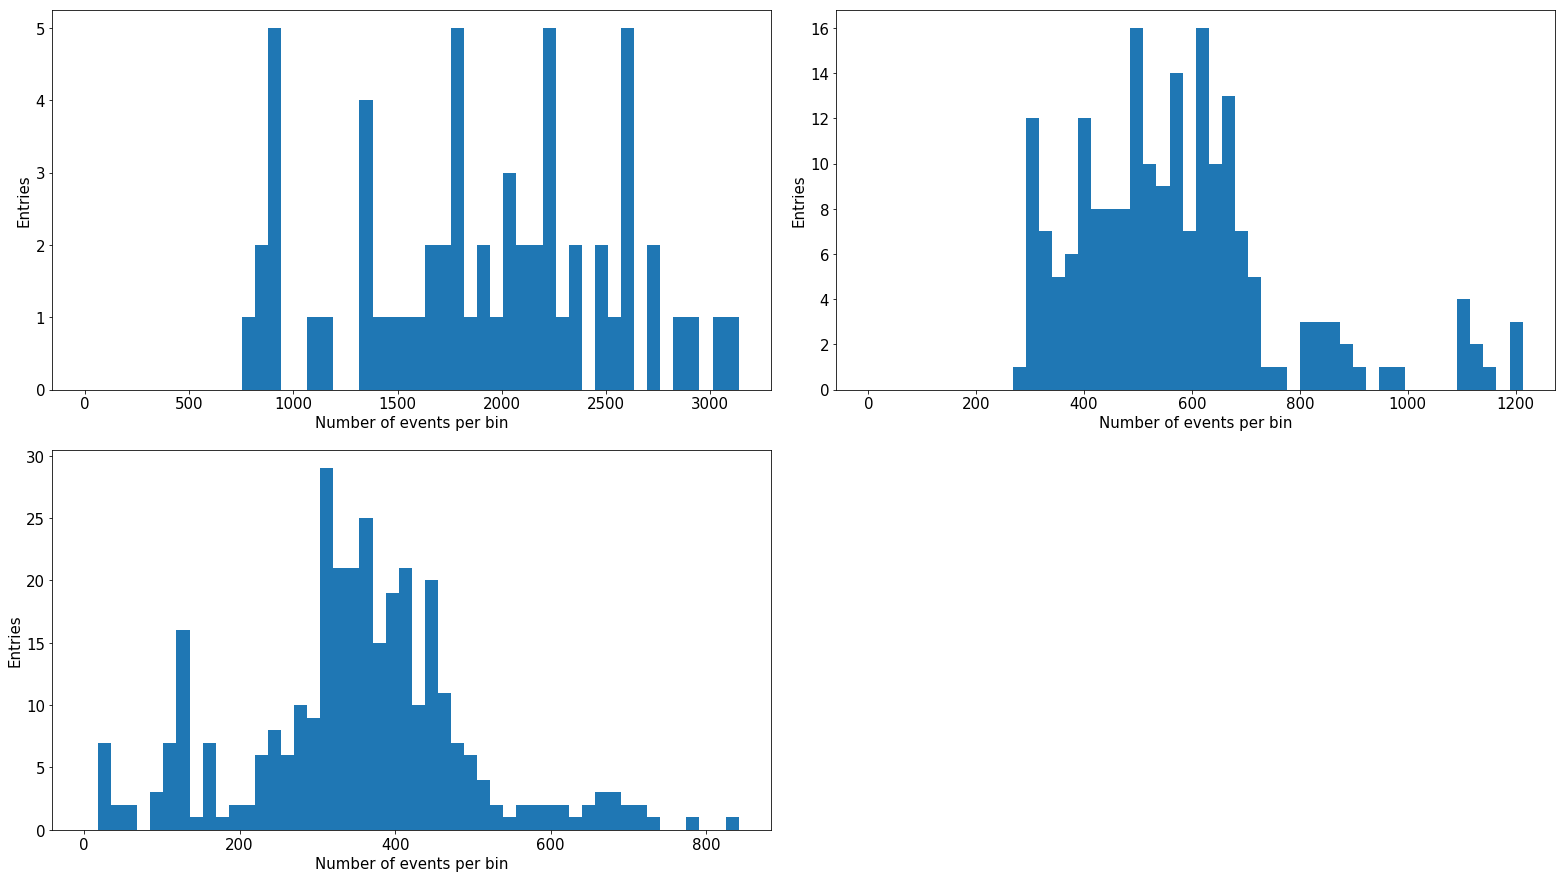

In [44]:
#for i, n in enumerate(XYnbins, start=1):
i = 1
for iL, iR in zip(Lnbins, Rnbins):
    nevt     = Nevt[(iL, iR)]
    lpitch  = Lpitch[iL]
    rpitch  = Rpitch[iR]
    nevt_max = int(np.max(nevt))

    plt.subplot(3, 2, i)
    plt.hist(nevt.flatten(), 50, (1, nevt_max + 1))
    labels("Number of events per bin", "Entries", f"# events per bin for {lpitch:.1f} and {rpitch:.1f} mm pitch")
    i += 1

plt.tight_layout()
save("Event_distribution_different_pitches_"+added_string)

In [45]:
Eave  = {}
Eaveu = {}

E_mean  = {}
Eu_mean = {}
E_std   = {}
Eu_std  = {}

E_min  = {}
E_max  = {}
Eu_min = {}
Eu_max = {}


for nL, nR in zip(Lnbins, Rnbins):
    
    *_, Eave_, Eaveu_ = fitf.profileXY(reco_z, reco_r, photo_response, nL, nR, Lrange, Rrange)
    Eaveu_            = relative_errors(Eave_, Eaveu_, percentual=True)   
    #Eok               = Eave_ > 1e3
    Eok               = Eave_ > 0.
   
    Eave   [(nL, nR)] = Eave_
    Eaveu  [(nL, nR)] = Eaveu_
    
    E_mean [(nL, nR)] = np.mean(Eave_ [Eok])
    E_std  [(nL, nR)] = np.std (Eave_ [Eok])

    Eu_mean[(nL, nR)] = np.mean(Eaveu_[Eok])
    Eu_std [(nL, nR)] = np.std (Eaveu_[Eok])
    
    E_min  [(nL, nR)] =      E_mean[(nL, nR)] - 3.0 *  E_std[(nL, nR)]
    E_max  [(nL, nR)] =      E_mean[(nL, nR)] + 2.0 *  E_std[(nL, nR)]

    Eu_min [(nL, nR)] = max(Eu_mean[(nL, nR)] - 1.5 * Eu_std[(nL, nR)], 1e-3)
    Eu_max [(nL, nR)] =     Eu_mean[(nL, nR)] + 2.0 * Eu_std[(nL, nR)]

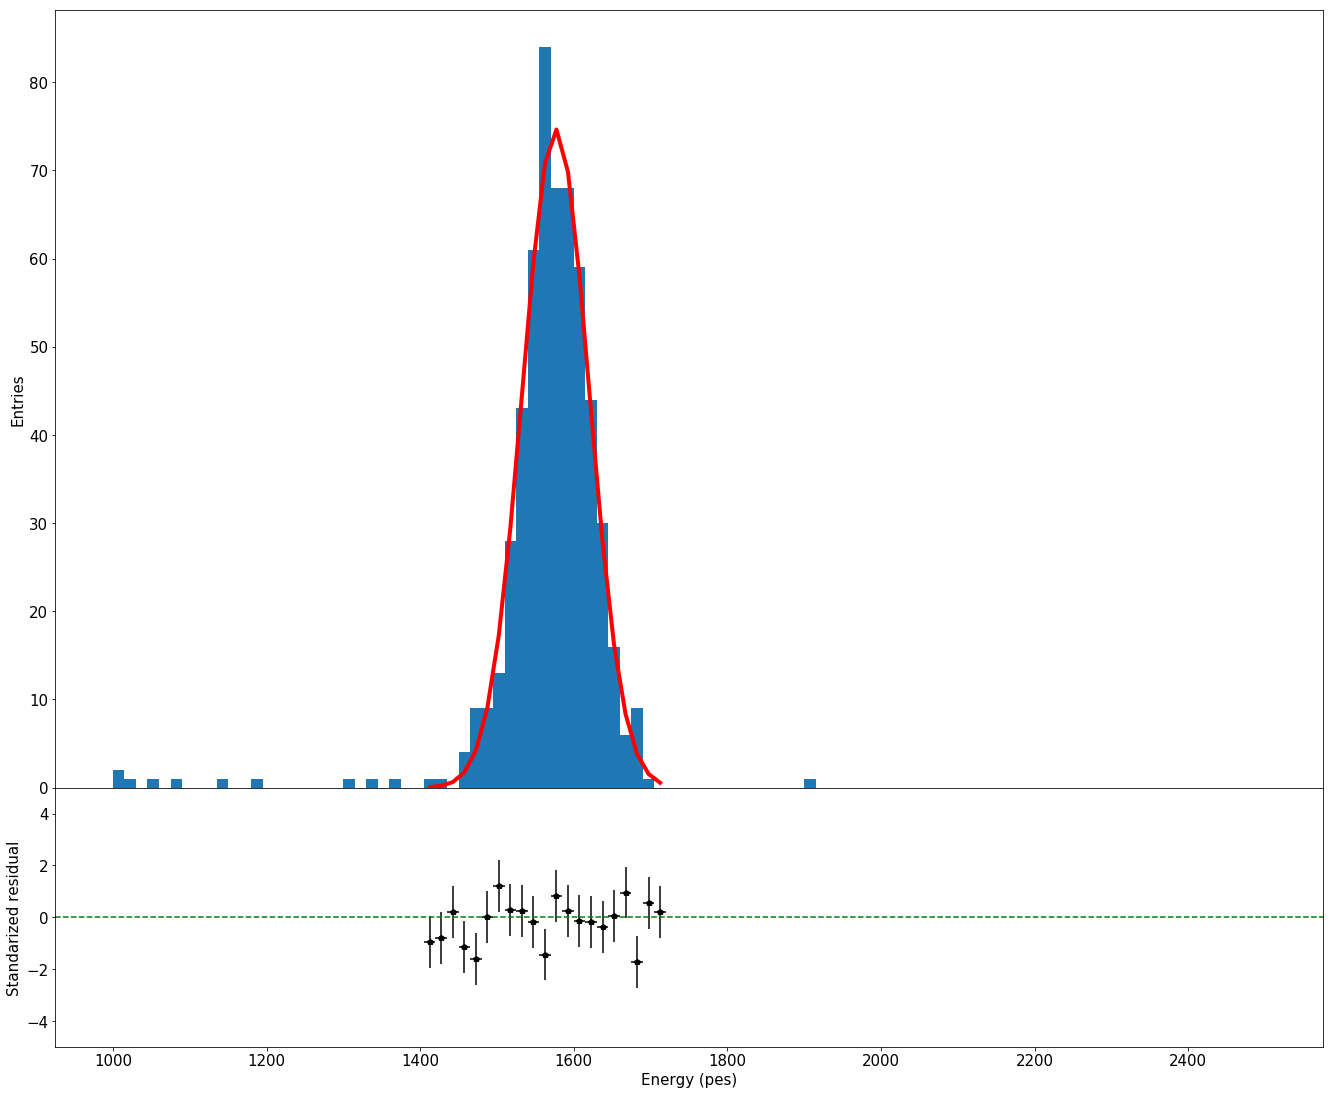

In [46]:
llim =  10,  12.5
rlim = 10, 12.5
sel  = in_range(reco_z, *llim) & in_range(reco_r, *rlim)
e    = photo_response[sel]
#print(e)
range_0 = (1500, 2400)
range_2 = (1000, 2500)
range_3 = (1000, 3000)

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
y, x, _   = hist(e, 100, range=range_2, new_figure=False)
seed      = gauss_seed(x, y)
fit_range = seed[1] - 2. * seed[2], seed[1] + 2. * seed[2]
x, y      = x[in_range(x, *fit_range)], y[in_range(x, *fit_range)]
f         = fitf.fit(fitf.gauss, x, y, seed, sigma=poisson_sigma(y))
plt.plot(x, f.fn(x), "r-", lw=4)

frame_data.set_xticklabels([])
labels("", "Entries", "Energy fit example")
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(x, (f.fn(x) - y) / poisson_sigma(y), 1, np.diff(x)[0] / 2, fmt="p", c="k")
plt.plot(lims, (0, 0), "g--")
plt.xlim(*lims)
plt.ylim(-5, +5)
labels("Energy (pes)", "Standarized residual")

save("Energy_fit_example_" + added_string)

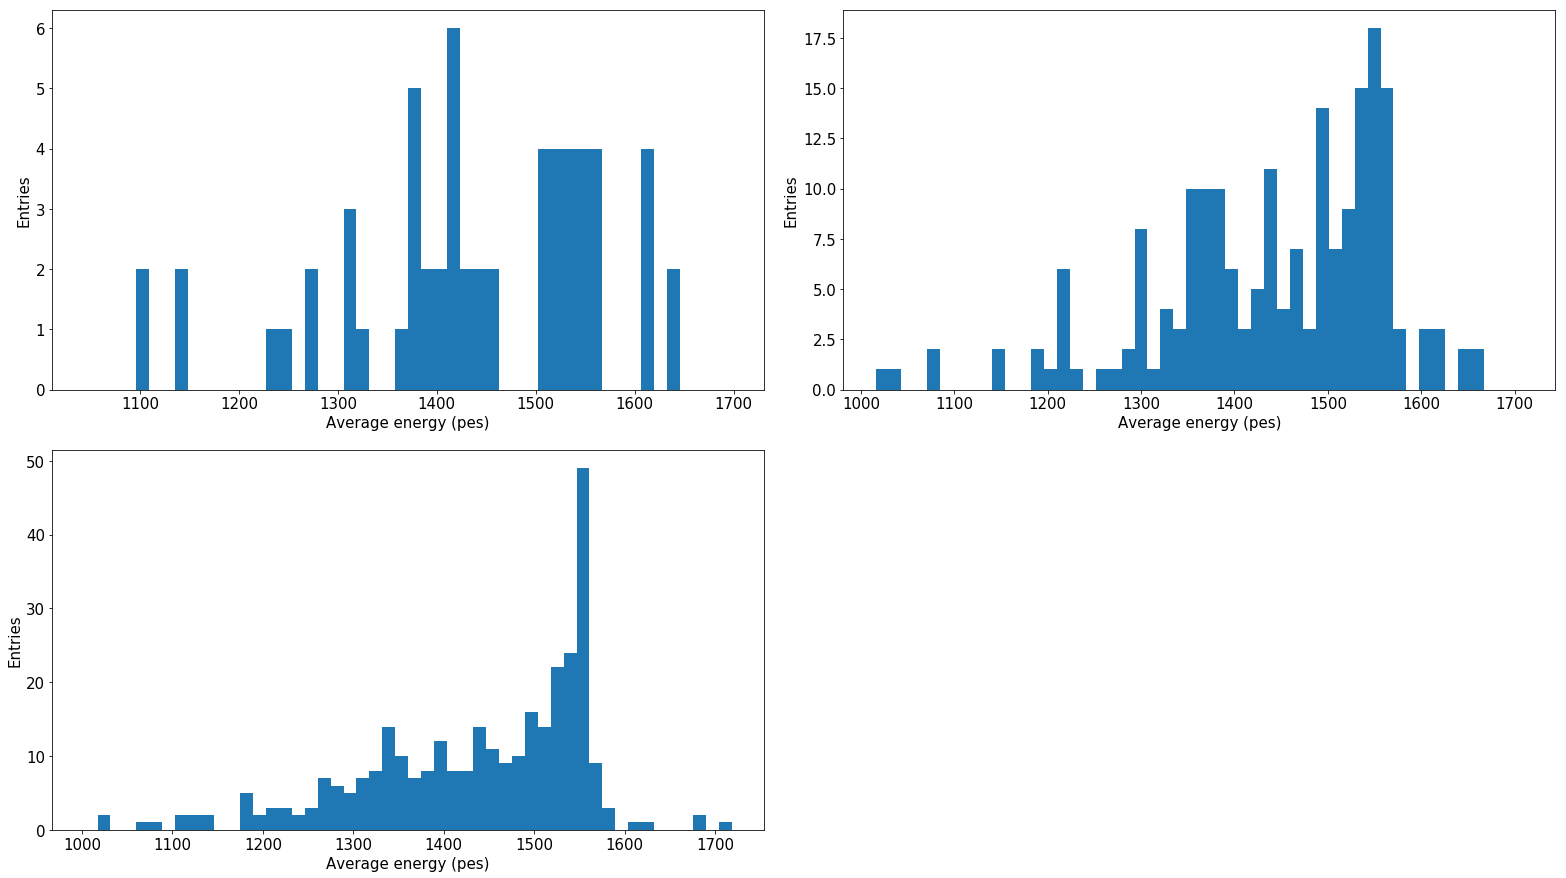

In [47]:
i = 1
for nL, nR in zip(Lnbins, Rnbins):
    lpitch = Lpitch[nL]
    rpitch = Rpitch[nR]
    plt.subplot(3, 2, i)
    plt.hist(Eave[(nL, nR)].flatten(), 50, (E_min[(nL, nR)], E_max[(nL, nR)]))
    labels("Average energy (pes)", "Entries", f"Average energy for {lpitch:.1f} and {rpitch:.1f} mm pitch")
    i += 1

plt.tight_layout()
save("Energy_distributions_" + added_string)

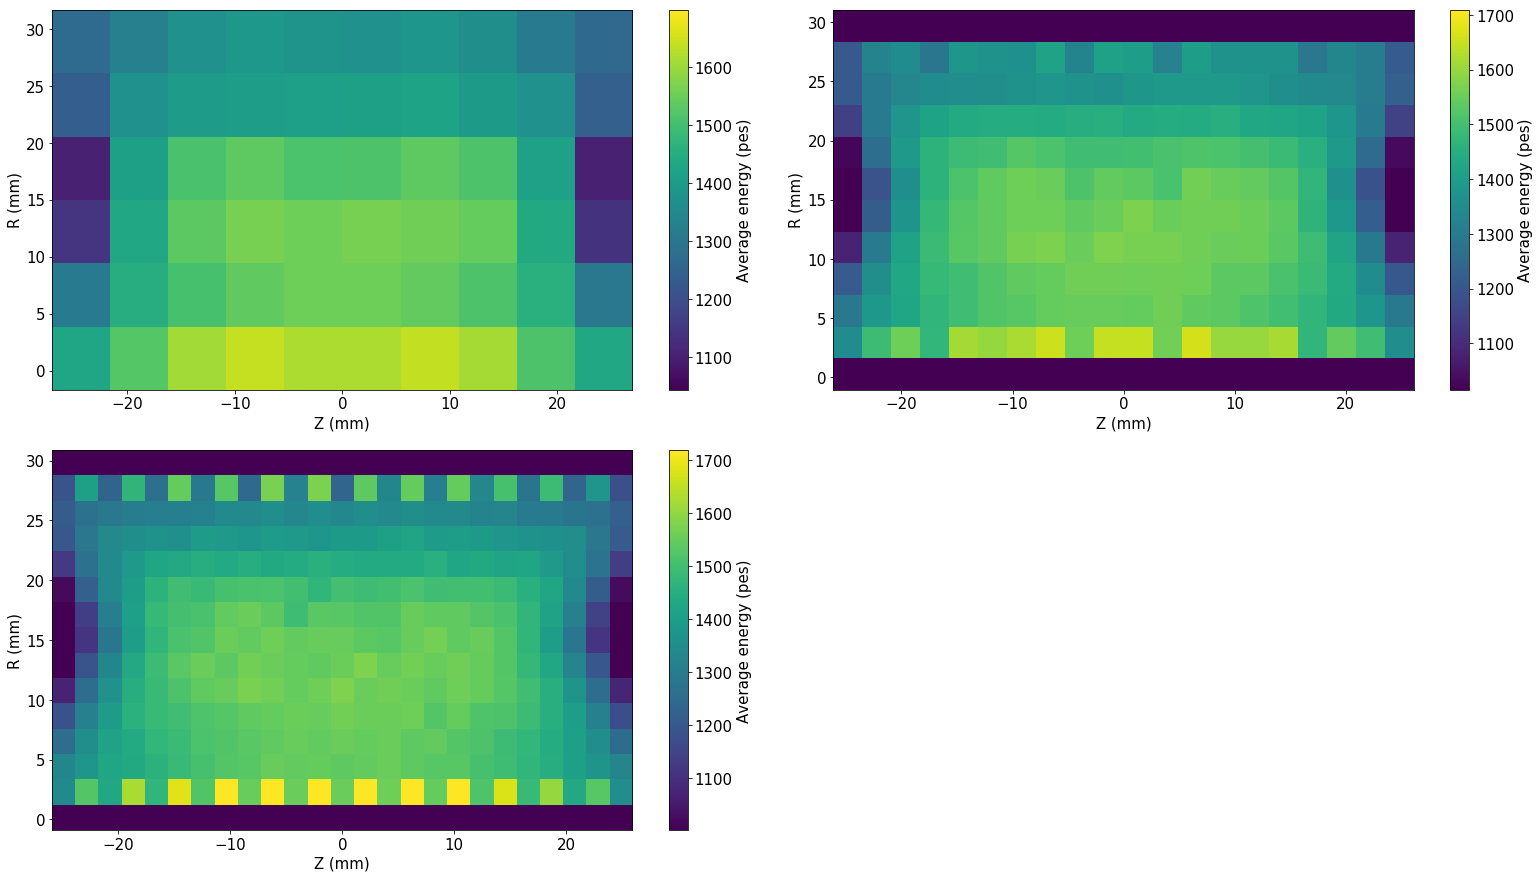

In [48]:
i = 1
for nL, nR in zip(Lnbins, Rnbins):
    lpitch = Lpitch[nL]
    rpitch = Rpitch[nR]
    plt.subplot(3, 2, i)
    *_, cb = display_matrix(Lcenters[nL], Rcenters[nR], Eave[(nL, nR)],
                            vmin = E_min[(nL, nR)],
                            vmax = E_max[(nL, nR)],
                            cmap = default_cmap,
                            new_figure = False)
    cb.set_label("Average energy (pes)")
    labels("Z (mm)", "R (mm)", f"Average energy for {lpitch:.1f} and {rpitch:.1f} mm pitch")
    i += 1

plt.tight_layout()
save("Energy_maps_" + added_string)

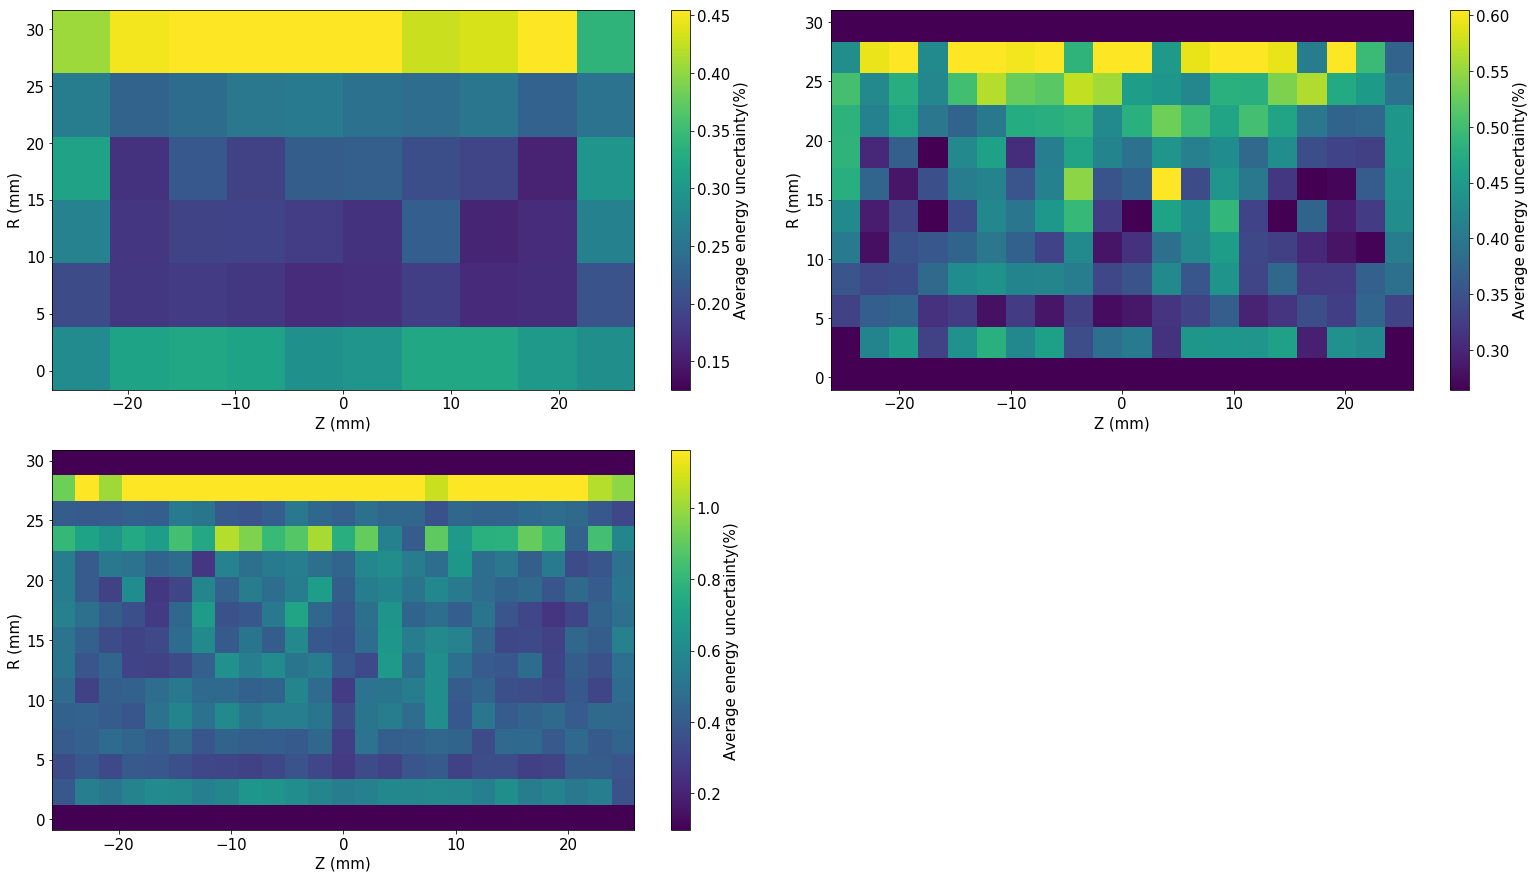

In [49]:
i = 1
for nL, nR in zip(Lnbins, Rnbins):
    lpitch = Lpitch[nL]
    rpitch = Rpitch[nR]
    plt.subplot(3, 2, i)
    *_, cb = display_matrix(Lcenters[nL], Rcenters[nR], Eaveu[(nL, nR)],
                            vmin = Eu_min[(nL, nR)],
                            vmax = Eu_max[(nL, nR)],
                            cmap = default_cmap,
                            new_figure = False)
    cb.set_label("Average energy uncertainty(%)")
    labels("Z (mm)", "R (mm)", f"Average energy unc. for {lpitch:.1f} and {rpitch:.1f} mm pitch")
    i += 1

plt.tight_layout()
save("Energy_uncertainty_maps_" + added_string)

In [51]:
with tb.open_file(correction_filename, "w") as output_file:
    for nL, nR in zip(Lnbins, Rnbins):
        lpitch = Lpitch[nL]
        rpitch = Rpitch[nR]
        group      =  "ZRcorrections"
        table_name = f"GeometryE_{lpitch:.1f}mm_{rpitch:.1f}mm"
        if (group      in output_file.root                 and
            table_name in getattr(output_file.root, group)):
            output_file.remove_node(getattr(output_file.root, group), table_name)
        write = kdstio.xy_correction_writer(output_file,
                                            group      = group,
                                            table_name = table_name)
        write(Lcenters[nL], Rcenters[nR], Eave[(nL, nR)], Eaveu[(nL, nR)] * Eave[(nL, nR)] / 100, Nevt[(nL, nR)])

        table = getattr(getattr(output_file.root, group), table_name)
        table.attrs.l_bins  = nL
        table.attrs.r_bins  = nR
        table.attrs.l_pitch = lpitch
        table.attrs.r_pitch = rpitch

In [33]:
cfile = tb.open_file(correction_filename, 'r')

In [35]:
cfile.root.ZRcorrections

/ZRcorrections (Group) ''
  children := ['GeometryE_2.0mm_2.0mm' (Table), 'GeometryE_2.5mm_2.5mm' (Table), 'GeometryE_5.0mm_5.0mm' (Table)]

### Correct the energy

In [52]:
correction_filename  = '/Users/paola/PETALO/analysis/corrections_full_ring_4mm_{}.h5'.format(added_string)
corrections  = dstf.load_xy_corrections(correction_filename,
                                    group = "ZRcorrections",
                                    node = f"GeometryE_2.5mm_2.5mm",
                                    norm_strategy = "index",
                                    norm_opts = {"index": (10,1)})

In [53]:
corr_charge = []
for z, r, c in zip(reco_z, reco_r, photo_response):
    corr_charge.append(c * corrections(z, r).value)

In [54]:
fid_z = in_range(reco_z, -22.5, 22.5)
fid_r = in_range(reco_r, 2.5, 27.5)
fid_louse = fid_z & fid_r

fid_z = in_range(reco_z, -17.5, 17.5)
fid_r = in_range(reco_r, 5, 25.)
fid_tight = fid_z & fid_r

fid_z = in_range(reco_z, -15., 15.)
fid_r = in_range(reco_r, 5, 25.)
fid_super_tight = fid_z & fid_r

In [40]:
fid_z

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [55]:
corr_charge = np.array(corr_charge)

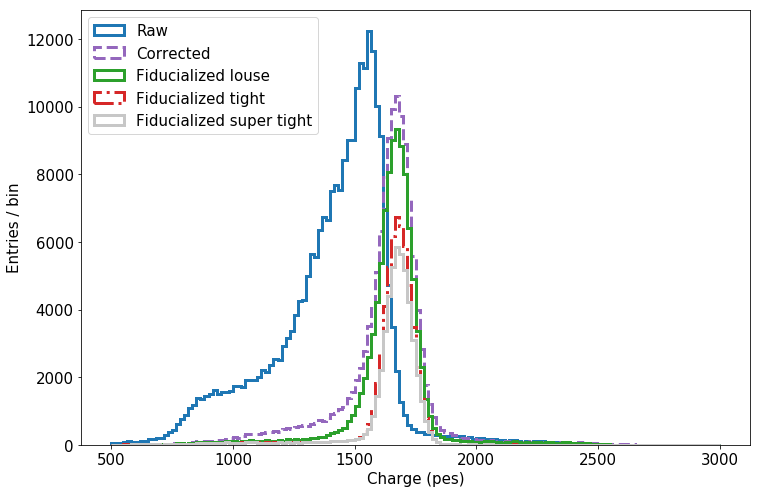

In [56]:
fig = plt.figure(1)
fig.set_figwidth(12.)
fig.set_figheight(8.)

plot_range = (500, 3000)
bins = 150

h1 = plt.hist(photo_response, bins=bins, color=blue, range=plot_range, histtype='step', 
              stacked=True, fill=False, label='Raw', linewidth=3.0,)
h2 = plt.hist(corr_charge, bins=bins, color=purple, range=plot_range, histtype='step', 
              stacked=True, fill=False, label='Corrected', linewidth=3.0, linestyle='--')
h3 = plt.hist(corr_charge[fid_louse], bins=bins, color=green, range=plot_range, histtype='step', 
              stacked=True, fill=False, label='Fiducialized louse', linewidth=3.0, linestyle='-')
h4 = plt.hist(corr_charge[fid_tight], bins=bins, color=red, range=plot_range, histtype='step', 
              stacked=True, fill=False, label='Fiducialized tight', linewidth=3.0, linestyle='-.')
h5 = plt.hist(corr_charge[fid_super_tight], bins=bins, color=grey, range=plot_range, histtype='step', 
              stacked=True, fill=False, label='Fiducialized super tight', linewidth=3.0, linestyle='-')

lnd = plt.legend(loc=2)
plt.xlabel('Charge (pes)')
plt.ylabel('Entries / bin')

In [57]:
fig.savefig('full-ring_4mm_{}.pdf'.format(added_string))

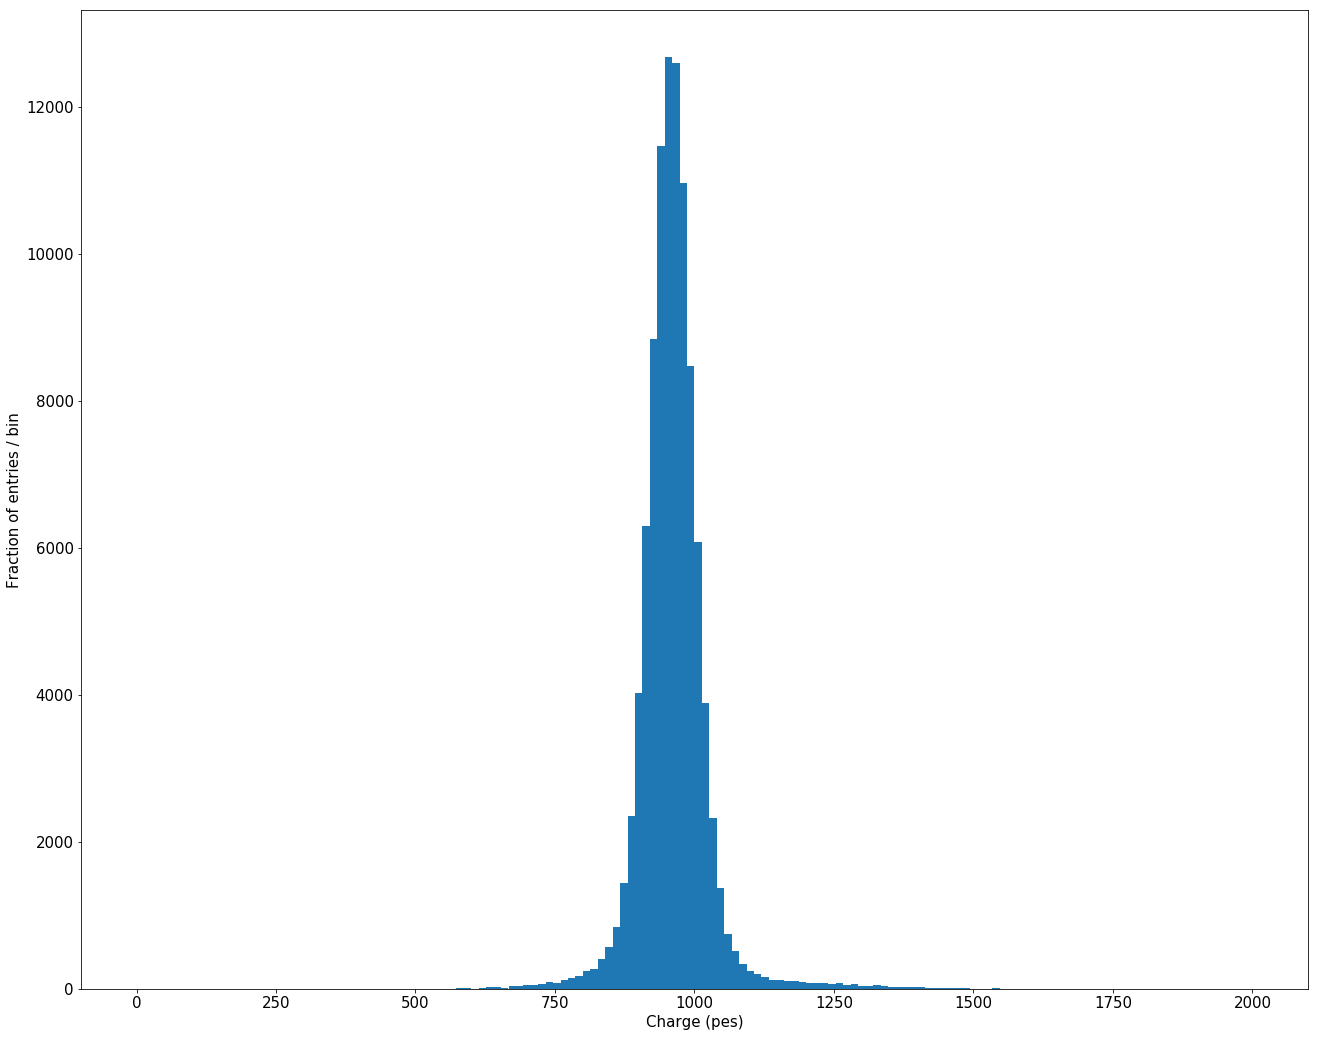

In [46]:
y, x, _ = plt.hist(corr_charge[fid], bins=150, range=(0,2000.))
plt.xlabel('Charge (pes)')
plt.ylabel('Fraction of entries / bin')

In [31]:
import textwrap
from invisible_cities.evm.ic_containers   import Measurement
from invisible_cities.icaro.hst_functions import measurement_string

def gtext(values, errors):
    """
    Build a string to be displayed within a matplotlib plot.
    """
    return textwrap.dedent("""
        $\mu$ = {0}
        $\sigma$ = {1}
        res = {2}
        """.format(measurement_string(values[0] , errors[0]),
                                  measurement_string(values[1] , errors[1]), 2.35*values[1]/values[0]))

[  5.48615762e+05   1.67938437e+03   5.43994219e+01]
[  2.85266206e+03   3.24322661e-01   3.31168366e-01]
2745.02239776


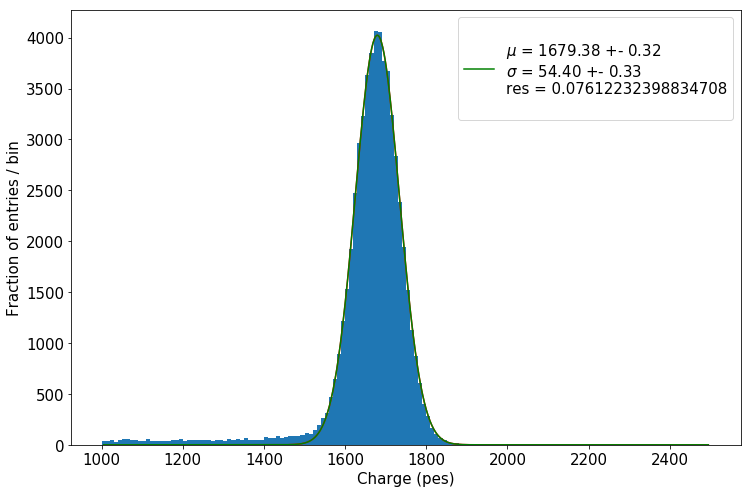

In [60]:
fig = plt.figure(1)
fig.set_figwidth(12.)
fig.set_figheight(8.)

y, x, _ = hist(corr_charge[fid_tight], bins=150, range=(1000,2500.), new_figure=False)
plt.xlabel('Charge (pes)')
plt.ylabel('Fraction of entries / bin')
seed = 10, 1700, 10
f    = fitf.fit(gauss, x, y, seed, fit_range=(1500, 1800))
print(f.values)
print(f.errors)
print(f.chi2)
#plt.text(gtext(f.values[1:],f.errors[1:]))
legend = gtext(f.values[1:],f.errors[1:])
xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-', label=legend)
lnd = plt.legend(loc=1)

In [61]:
fig.savefig('res-fid_4mm_{}.pdf'.format(added_string))